# 0. Imports packages, modules and functions

## 0.1. Import modules

In [2]:
import pandas                   as pd
import numpy                    as np
import seaborn                  as sns
import matplotlib.pyplot        as plt
import umap.umap_               as ump


from scipy                      import stats
from scipy.cluster              import hierarchy    as hc
from plotly                     import express as px
from sklearn                    import mixture as mx
from sklearn                    import cluster
from sklearn                    import decomposition
from sklearn                    import metrics
from sklearn.ensemble           import RandomForestRegressor
from sklearn.preprocessing      import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.manifold           import TSNE
from pandas_profiling           import ProfileReport
from sqlalchemy                 import create_engine
from matplotlib                 import cm

import json
import datetime
import inflection
import math
import random
import warnings
import re
import sqlite3

warnings.filterwarnings('ignore')
%matplotlib inline

## 0.2. Helper functions

In [8]:
def cramer_v(x, y):
    cm = pd.crosstab(x, y).as_matrix()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency(cm)[0]
    chi2_corrected = chi2 - ((k - 1)*(r - 1))/(n - 1)
    k_corrected = k - ((k - 1)**2)/(n - 1)
    r_corrected = r - ((r - 1)**2)/(n - 1)
    
    return np.sqrt((chi2_corrected/n) / (min(k_corrected - 1, r_corrected - 1)))

def get_class_count(df, identification, target_var):
    
    class_count = df.groupby([target_var])[identification].nunique()
    return {key: class_count[key] for key in list(class_count.keys())}

def get_class_proportion(df, identification, target_var):
    
    class_counts = get_class_count(df, identification , target_var)
    return {val[0]: round(100 * val[1]/df.shape[0], 2) for val in class_counts.items()}

def performance(model, x_train, y_train):
    # define scoring metrics
    scoring = {'accuracy': 'accuracy',
               'precision': make_scorer(precision_score),
               'recall': make_scorer(recall_score),
               'f1_score': make_scorer(f1_score),
               'roc_auc_score': make_scorer(roc_auc_score),
               'mcc': make_scorer(matthews_corrcoef)}

    # calculate scores with cross_validate
    scores = cross_validate(model, x_train, y_train, cv=10, scoring=scoring)

    # performance data frame
    performance = pd.DataFrame.from_dict(scores).drop(['fit_time', 'score_time'], axis=1)
    performance = pd.DataFrame(performance.mean()).T
    return performance

def performance_test(model_name, model, x_test, y_test):
    # predcitions
    yhat = model.predict(x_test)
    
    # Performance metrics
    precision = precision_score(y_test, yhat)
    recall = recall_score(y_test, yhat)
    f1 = f1_score(y_test, yhat)
    roc_auc = roc_auc_score(y_test, yhat)
    mcc = matthews_corrcoef(y_test, yhat)

    # Performance dataframe
    performance_df = pd.DataFrame({'precision': precision, 'recall': recall, 'f1_score': f1, 
                               'roc_auc_score': roc_auc, 'mcc': mcc}, index=[model_name])

    # confusion matrix
    cm = confusion_matrix(y_test, yhat)

    # dataframe for heatmap
    cm_df = pd.DataFrame(cm, columns=['predicted_not_churn', 'predicted_churn'], 
                         index=['actual_not_churn', 'actual_churn'])
    
    return performance_df, cm_df

def silhouette_analysis(n_clusters, labels, data):
    '''
    Functions that analyzes the silhouette of a previous trained clustering model, for n chosen clusters and data.
    
    param n_clusters
    List of integers representing the number of clusters that will be analyzed.
    
    param labels
    Array of labels obtained from the model prediction. Attention that the data used to create the labels, must be coherent with the data used in this function.
    
    param data
    The dataframe used to generate the labels.
    '''
    from sklearn.metrics import silhouette_samples
    
    fig, ax = plt.subplots( int(len(n_clusters)/2.0) + 1, 2 )
    fig.set_size_inches(25,20)
    
    for k in n_clusters:
        
        q,mod = divmod(k, 2)
        
        ax[q-1, mod].set_xlim([-0.1, 1])
        ax[q-1, mod].set_ylim([0, len(data)])
        
        silhouette_samples_values = silhouette_samples(data, labels)
        
        y_start = 0
        
        for i in range(k):
            
            # selecting the cluster i
            i_th_samples = silhouette_samples_values[labels == i]
            
            # sorting the values
            i_th_samples.sort()
            
            # sizing the cluster i
            size_cluster_i = i_th_samples.shape[0]
            y_end = y_start + size_cluster_i
            
            # updating the color
            cmap = cm.get_cmap('Spectral')
            color = cmap(i / k)
            
            # ploting the silhouette for cluster i
            ax[q-1,mod].fill_betweenx(np.arange(y_start, y_end), 0, i_th_samples)
            
            # updating y axis
            y_start = y_end
            
        ax[q-1,mod].set_yticks([])
        ax[q-1,mod].set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        
    plt.show()
    
def plot_embedded_space(data, embedding, n_components,  title, fig_name=None, figsize=(10,10)):

    fig = plt.figure(figsize=figsize)

    if n_components == 1:

        data['embedding_x'] = embedding[:,0]

        ax = fig.add_subplot(111)
        ax.scatter(data['embedding_x'], range(len(data[['embedding_x']])))
    elif n_components == 2:

        data['embedding_x'] = embedding[:,0]
        data['embedding_y'] = embedding[:,1]

        ax = fig.add_subplot(111)
        ax.scatter(data['embedding_x'], data['embedding_y'])
    elif n_components == 3:

        data['embedding_x'] = embedding[:,0]
        data['embedding_y'] = embedding[:,1]
        data['embedding_z'] = embedding[:,2]

        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(data['embedding_x'], data['embedding_y'], data['embedding_z'])
        
    ax.set_title(title)
    
    if fig_name != None:
        
        plt.savefig(fig_name, dpi=fig.dpi)
    
    plt.show()
    return None

## 0.3. Loading data

In [9]:
# load data
path = '/home/pedro/Documents/repos/3-insiders-clustering'
df_raw = pd.read_csv(path + '/data/raw/Ecommerce.csv', encoding = "ISO-8859-1" )

# drop extra column
df_raw = df_raw.drop( columns=['Unnamed: 8'], axis=1 )

## 0.4. Image controls

In [10]:
def jupyter_settings():
        
    pd.set_option('display.float_format', '{:.6e}'.format)
    plt.rcParams.update({'font.size': 27})
    plt.rcParams["font.family"] = "sans-serif"
    plt.figure(facecolor='white')
    fig_size = (16, 8) # Parameter used to size every graph
        
    %matplotlib inline
    
    #plt.style.use( 'classic')
    plt.rcParams['figure.figsize'] = [24, 15]
    plt.rcParams['font.size'] = 16
    
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    #sns.set_theme(font_size=24)
    
    return None

jupyter_settings()


# 1. Data description

In [11]:
df1 = df_raw.copy()

## 1.1. Rename columns

In [12]:
df1.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [13]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']

df1.columns = cols_new
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.550000e+00,1.785000e+04,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.390000e+00,1.785000e+04,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.750000e+00,1.785000e+04,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.390000e+00,1.785000e+04,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.390000e+00,1.785000e+04,United Kingdom


## 1.2. Data dimensions

In [14]:
print( 'Number of rows: {}'.format( df1.shape[0] ) )
print( 'Number of cols: {}'.format( df1.shape[1] ) )

Number of rows: 541909
Number of cols: 8


The dataset consist of more than 500,000 items purchases with different purchases must refer to the same purchase order and customer, while it has only 8 columns.

## 1.3. Data types

In [15]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

The types of the invoice number, customer id and invoice date seem to have the wrong type. Customer ID and invoice number should be represented by the int number type, while the invoice date should be represented by a datetime.

## 1.4. Check NA

In [16]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5. Replacing NA

In [17]:
df_missing = df1.loc[df1['customer_id'].isna(),:]
df_not_missing = df1.loc[~df1['customer_id'].isna(),:]

# create reference
df_backup = pd.DataFrame(df_missing['invoice_no'].drop_duplicates())
df_backup['customer_id'] = np.arange(19000, 19000+len(df_backup), 1)

# merge original with reference dataframe
df1 = pd.merge(df1, df_backup, on='invoice_no', how='left')

# Coalescing columns customer_id_x and customer_id_y
df1['customer_id'] = df1['customer_id_x'].combine_first(df1['customer_id_y'])

# Droping extra customer_id columns
df1 = df1.drop(columns=['customer_id_x', 'customer_id_y'], axis=1)

In [18]:
df1 = df1.dropna(subset=['description', 'customer_id'])

print('Removed data: {:.2f}%'.format(100*(1 - (df1.shape[0]/df_raw.shape[0]))))

Removed data: 0.27%


In [19]:
df1.isna().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
country         0
customer_id     0
dtype: int64

The data has many problems with NA purchase orders, that may be represented by some business problem or relevant information, such as reversed logistics to product change or devolution. It can be represented by both the negative quantities and the letters whitin the invoice number. All those data will be removed from the dataset.

## 1.6. Change dtypes

In [20]:
 # invoice date
df1['invoice_date'] = pd.to_datetime( df1['invoice_date'], format='%d-%b-%y' )

# customer id
df1['customer_id'] = df1['customer_id'].astype( int )
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.550000e+00,United Kingdom,17850
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.390000e+00,United Kingdom,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.750000e+00,United Kingdom,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.390000e+00,United Kingdom,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.390000e+00,United Kingdom,17850


In [21]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object

Even after the removal of NA values, it was not possible to remove all invoice numbers with a letter in it. So, it was not possible to change the invoice number type. Maybe it could be necessary to create features that properly represents the business problem behind the reason of a letter to appear in it. 

# 2. Variable filtering

In [22]:
df2 = df1.copy()

All values of clients with a quantity equal or lesser than 0 will be removed from the dataset, since this type of customer will not be elected as a insider anyway. Afterwards, the quantity column will be removed, since its information is contained inside the ticket per product.

In [23]:
# prices higher than 1 cent
df2 = df2.loc[(df1['unit_price'] > 0.01), :]

# customer from a known region
df2 = df2[~df2['country'].isin(['European Community', 'Unspecified' ] ) ]

# stock code different from not explained codes
df2 = df2[~df2['stock_code'].isin( ['POST' 'D' 'DOT' 'M' 'S' 'AMAZONFEE' 'm' 'DCGSSBOY' 'DCGSSGIRL' 'PADS' 'B' 'CRUK'] ) ]

# returned products
df2_returns = df2.loc[df2['quantity'] < 0, :]
df2_returns['gross_returns'] = df2_returns['quantity'] * df2_returns['unit_price'] * (- 1)

# positive quantities
df2_purchase = df2.loc[(df2['quantity'] > 0), :]
df2_purchase.loc[:,'gross_purchases'] = df2_purchase.loc[:,'quantity'] * df2_purchase.loc[:,'unit_price']


# 3. Feature engineering

In [24]:
df3 = df2.copy()

## 3.1. Feature creation

The features will be created in order to adjust the clusterization problem with a RFM model solution. For this, the main features within the model will be the monetary, frequency and recency. The monetary consists of the total amount of revenue from a given client, the frequency measures how many different purchases the client has made, while the recency measures the difference between the actual date (highest date within the dataset) and the last purchase date.

In [25]:
# data reference
df_ref = df3.drop( ['invoice_no', 'stock_code', 'description', 'quantity',
                    'invoice_date', 'unit_price', 'country'], axis=1 ).drop_duplicates().reset_index(drop=True)

### 3.1.1. Gross purchases and devolutions

In [26]:
# Purchases
df3['purchases'] = df2_purchase['quantity'] * df2_purchase['unit_price']
df3['devolutions'] = df2_returns['quantity'] * df2_returns['unit_price']

# Monetary
df_monetary = df3[['customer_id', 'purchases', 'devolutions']].groupby( 'customer_id' ).sum().reset_index()
df_ref = pd.merge( df_ref, df_monetary, on='customer_id', how='left' )
df_ref.head(10)

,customer_id,purchases,devolutions
0,17850,5.391210e+03,-1.025800e+02
1,13047,3.237540e+03,-1.584400e+02
2,12583,7.281380e+03,-9.404000e+01
3,13748,9.482500e+02,0.000000e+00
4,15100,8.760000e+02,-2.409000e+02
5,15291,4.668300e+03,-7.179000e+01
6,14688,5.630870e+03,-5.234900e+02
7,17809,5.411910e+03,-7.842900e+02
8,15311,6.076790e+04,-1.348560e+03
9,14527,8.508820e+03,-7.974400e+02


### 3.1.2. Recency for purchases and devolutions - newest occurence

In [27]:
# Recency - Last day purchase
df_recency_p = df2_purchase[['customer_id', 'invoice_date']].groupby( 'customer_id' ).max().reset_index()
df_recency_p['recency_p'] = ( df3['invoice_date'].max() - df_recency_p['invoice_date'] ).dt.days
df_recency_p = df_recency_p[['customer_id', 'recency_p']].copy()
df_ref = pd.merge( df_ref, df_recency_p, on='customer_id', how='left' )

# Recency - Last day devolution
df_recency_d = df2_returns[['customer_id', 'invoice_date']].groupby( 'customer_id' ).max().reset_index()
df_recency_d['recency_d'] = ( df3['invoice_date'].max() - df_recency_d['invoice_date'] ).dt.days
df_recency_d = df_recency_d[['customer_id', 'recency_d']].copy()
df_ref = pd.merge( df_ref, df_recency_d, on='customer_id', how='left' )
df_ref.head(10)

,customer_id,purchases,devolutions,recency_p,recency_d
0,17850,5.391210e+03,-1.025800e+02,3.720000e+02,3.020000e+02
1,13047,3.237540e+03,-1.584400e+02,3.100000e+01,3.100000e+01
2,12583,7.281380e+03,-9.404000e+01,2.000000e+00,5.600000e+01
3,13748,9.482500e+02,0.000000e+00,9.500000e+01,NaN
4,15100,8.760000e+02,-2.409000e+02,3.330000e+02,3.300000e+02
5,15291,4.668300e+03,-7.179000e+01,2.500000e+01,1.720000e+02
6,14688,5.630870e+03,-5.234900e+02,7.000000e+00,7.000000e+00
7,17809,5.411910e+03,-7.842900e+02,1.600000e+01,1.600000e+01
8,15311,6.076790e+04,-1.348560e+03,0.000000e+00,0.000000e+00
9,14527,8.508820e+03,-7.974400e+02,2.000000e+00,8.000000e+00


### 3.1.3. Quantity of product pruchased or returned

In [28]:
# Frequency - both purchases and returns
df_freq_p = df2_purchase[['customer_id', 'quantity']].drop_duplicates().groupby( 'customer_id' ).sum().reset_index().rename(columns={'quantity':'quantity_p'})
df_ref = pd.merge( df_ref, df_freq_p, on='customer_id', how='left' )

df_freq_d = df2_returns[['customer_id', 'quantity']].drop_duplicates().groupby( 'customer_id' ).sum().reset_index().rename(columns={'quantity':'quantity_d'})
df_ref = pd.merge( df_ref, df_freq_d, on='customer_id', how='left' )
df_ref.head(10)

,customer_id,purchases,devolutions,recency_p,recency_d,quantity_p,quantity_d
0,17850,5.391210e+03,-1.025800e+02,3.720000e+02,3.020000e+02,3.500000e+01,-2.100000e+01
1,13047,3.237540e+03,-1.584400e+02,3.100000e+01,3.100000e+01,1.320000e+02,-6.000000e+00
2,12583,7.281380e+03,-9.404000e+01,2.000000e+00,5.600000e+01,1.569000e+03,-5.000000e+01
3,13748,9.482500e+02,0.000000e+00,9.500000e+01,NaN,1.690000e+02,NaN
4,15100,8.760000e+02,-2.409000e+02,3.330000e+02,3.300000e+02,4.800000e+01,-2.200000e+01
5,15291,4.668300e+03,-7.179000e+01,2.500000e+01,1.720000e+02,5.080000e+02,-2.700000e+01
6,14688,5.630870e+03,-5.234900e+02,7.000000e+00,7.000000e+00,5.790000e+02,-2.810000e+02
7,17809,5.411910e+03,-7.842900e+02,1.600000e+01,1.600000e+01,9.610000e+02,-4.100000e+01
8,15311,6.076790e+04,-1.348560e+03,0.000000e+00,0.000000e+00,2.167000e+03,-2.310000e+02
9,14527,8.508820e+03,-7.974400e+02,2.000000e+00,8.000000e+00,1.980000e+02,-3.000000e+00


### 3.1.4. Quantity of invoices for purchases and returns

In [29]:
# Frequency - both purchases and returns
df_invoices_p = df2_purchase[['customer_id', 'invoice_no']].drop_duplicates().groupby( 'customer_id' ).count().reset_index().rename(columns={'invoice_no':'invoices_p'})
df_ref = pd.merge( df_ref, df_invoices_p, on='customer_id', how='left' )

df_invoices_d = df2_returns[['customer_id', 'invoice_no']].drop_duplicates().groupby( 'customer_id' ).count().reset_index().rename(columns={'invoice_no':'invoices_d'})
df_ref = pd.merge( df_ref, df_invoices_d, on='customer_id', how='left' )
df_ref.head(10)

,customer_id,purchases,devolutions,recency_p,recency_d,quantity_p,quantity_d,invoices_p,invoices_d
0,17850,5.391210e+03,-1.025800e+02,3.720000e+02,3.020000e+02,3.500000e+01,-2.100000e+01,3.400000e+01,1.000000e+00
1,13047,3.237540e+03,-1.584400e+02,3.100000e+01,3.100000e+01,1.320000e+02,-6.000000e+00,1.000000e+01,8.000000e+00
2,12583,7.281380e+03,-9.404000e+01,2.000000e+00,5.600000e+01,1.569000e+03,-5.000000e+01,1.500000e+01,3.000000e+00
3,13748,9.482500e+02,0.000000e+00,9.500000e+01,NaN,1.690000e+02,NaN,5.000000e+00,NaN
4,15100,8.760000e+02,-2.409000e+02,3.330000e+02,3.300000e+02,4.800000e+01,-2.200000e+01,3.000000e+00,3.000000e+00
5,15291,4.668300e+03,-7.179000e+01,2.500000e+01,1.720000e+02,5.080000e+02,-2.700000e+01,1.500000e+01,5.000000e+00
6,14688,5.630870e+03,-5.234900e+02,7.000000e+00,7.000000e+00,5.790000e+02,-2.810000e+02,2.100000e+01,6.000000e+00
7,17809,5.411910e+03,-7.842900e+02,1.600000e+01,1.600000e+01,9.610000e+02,-4.100000e+01,1.200000e+01,3.000000e+00
8,15311,6.076790e+04,-1.348560e+03,0.000000e+00,0.000000e+00,2.167000e+03,-2.310000e+02,9.100000e+01,2.700000e+01
9,14527,8.508820e+03,-7.974400e+02,2.000000e+00,8.000000e+00,1.980000e+02,-3.000000e+00,5.500000e+01,3.100000e+01


### 3.1.5. Average ticket value

In [30]:
# average ticket - for purchases only
df_avg_ticket = df2_purchase.loc[:,['customer_id', 'gross_purchases']].groupby('customer_id').mean().reset_index().rename(columns={'gross_purchases':'avg_ticket'})
df_ref = pd.merge( df_ref, df_avg_ticket, on='customer_id', how='left' )
df_ref.head(10)

,customer_id,purchases,devolutions,recency_p,recency_d,quantity_p,quantity_d,invoices_p,invoices_d,avg_ticket
0,17850,5.391210e+03,-1.025800e+02,3.720000e+02,3.020000e+02,3.500000e+01,-2.100000e+01,3.400000e+01,1.000000e+00,1.815222e+01
1,13047,3.237540e+03,-1.584400e+02,3.100000e+01,3.100000e+01,1.320000e+02,-6.000000e+00,1.000000e+01,8.000000e+00,1.882291e+01
2,12583,7.281380e+03,-9.404000e+01,2.000000e+00,5.600000e+01,1.569000e+03,-5.000000e+01,1.500000e+01,3.000000e+00,2.947927e+01
3,13748,9.482500e+02,0.000000e+00,9.500000e+01,NaN,1.690000e+02,NaN,5.000000e+00,NaN,3.386607e+01
4,15100,8.760000e+02,-2.409000e+02,3.330000e+02,3.300000e+02,4.800000e+01,-2.200000e+01,3.000000e+00,3.000000e+00,2.920000e+02
5,15291,4.668300e+03,-7.179000e+01,2.500000e+01,1.720000e+02,5.080000e+02,-2.700000e+01,1.500000e+01,5.000000e+00,4.532330e+01
6,14688,5.630870e+03,-5.234900e+02,7.000000e+00,7.000000e+00,5.790000e+02,-2.810000e+02,2.100000e+01,6.000000e+00,1.721979e+01
7,17809,5.411910e+03,-7.842900e+02,1.600000e+01,1.600000e+01,9.610000e+02,-4.100000e+01,1.200000e+01,3.000000e+00,8.871984e+01
8,15311,6.076790e+04,-1.348560e+03,0.000000e+00,0.000000e+00,2.167000e+03,-2.310000e+02,9.100000e+01,2.700000e+01,2.554346e+01
9,14527,8.508820e+03,-7.974400e+02,2.000000e+00,8.000000e+00,1.980000e+02,-3.000000e+00,5.500000e+01,3.100000e+01,8.753930e+00


### 3.1.6. Average recency days

In [31]:
df_aux = df3[['customer_id', 'invoice_date']].drop_duplicates().sort_values(['customer_id','invoice_date'], ascending=[True, False])
df_aux['next_customer_id'] = df_aux['customer_id'].shift(-1) # next customer
df_aux['next_next_customer_id'] = df_aux['next_customer_id'].shift(-1) # next customer
df_aux['next_invoice_date'] = df_aux['invoice_date'].shift(-1) # next invoice date

#today =  datetime.datetime.fromtimestamp(df3['invoice_date'].max().to_datetime())
#today_date = datetime.datetime.strptime( today, '%Y-%m-%d')
today_date = df3['invoice_date'].max()

df_aux['avg_recency_days'] = df_aux.apply(lambda x: (x['next_invoice_date'] - x['invoice_date']).days if (x['customer_id'] == x['next_customer_id']) 
                                                                                                    else ( (x['next_invoice_date'] - x['invoice_date']) if (x['customer_id'] == x['next_next_customer_id']) 
                                                                                                                                                        else (today_date - x['invoice_date']).days), axis=1)
df_avg_recency_days = df_aux[['customer_id','avg_recency_days']].groupby('customer_id').mean().reset_index()

# Merging
df_ref = pd.merge(df_ref, df_avg_recency_days, on='customer_id', how='left')

print(df_aux.head(10))
#print(df_ref.head())

        customer_id invoice_date  next_customer_id  next_next_customer_id next_invoice_date  avg_recency_days
61619         12346   2017-01-16      1.234700e+04           1.234700e+04        2017-12-05               325
535004        12347   2017-12-05      1.234700e+04           1.234700e+04        2017-10-29               -37
428957        12347   2017-10-29      1.234700e+04           1.234700e+04        2017-07-31               -90
286621        12347   2017-07-31      1.234700e+04           1.234700e+04        2017-06-07               -54
220572        12347   2017-06-07      1.234700e+04           1.234700e+04        2017-04-05               -63
148285        12347   2017-04-05      1.234700e+04           1.234700e+04        2017-01-24               -71
72246         12347   2017-01-24      1.234700e+04           1.234800e+04        2016-12-05               -50
14938         12347   2016-12-05      1.234800e+04           1.234800e+04        2017-09-23               367
359058    

### 3.1.7. Basket size and unique products

In [32]:
df_aux = ( df2_purchase.loc[:,['customer_id','invoice_no','quantity']].groupby('customer_id')
                                                                       .agg(n_purchase=('invoice_no', 'nunique'),
                                                                            n_products=('quantity', 'sum'))
                                                                       .reset_index() )

df_aux['avg_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# Merge
df_ref = pd.merge(df_ref, df_aux, how='left', on='customer_id')

df_aux = ( df2_purchase.loc[:,['customer_id','invoice_no','stock_code']].groupby('customer_id')
                                                                       .agg(n_purchase=('invoice_no', 'nunique'),
                                                                            n_products=('stock_code', 'count'))
                                                                       .reset_index() )

df_aux['avg_variety'] = df_aux['n_products'] / df_aux['n_purchase']

# Merge
df_ref = pd.merge(df_ref, df_aux, how='left', on='customer_id')

### 3.1.8. Frequency - purchases per day

In [33]:
df_aux = ( df2_purchase[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates()
                                                            .groupby('customer_id')
                                                            .agg( max_=('invoice_date', 'max'),
                                                                  min_=('invoice_date', 'min'),
                                                                  buys_=('invoice_no','count'))
                                                            .reset_index()  )
# Calculating the days
df_aux['days_'] = df_aux[['max_','min_']].apply(lambda x: (x['max_'] - x['min_']).days + 1 , axis=1)

# Frequency
df_aux['purchases_pday'] = df_aux[['buys_','days_']].apply(lambda x: x['buys_'] / x['days_'] if (x['days_'] !=0 ) else 0, axis=1)

# Merging
df_ref = pd.merge(df_ref, df_aux[['customer_id','purchases_pday']], on='customer_id', how='left')
df_ref.sample(20)

,customer_id,purchases,devolutions,recency_p,recency_d,quantity_p,quantity_d,invoices_p,invoices_d,avg_ticket,avg_recency_days,n_purchase_x,n_products_x,avg_basket_size,n_purchase_y,n_products_y,avg_variety,purchases_pday
685,17576,3.622680e+03,-1.649000e+02,8.000000e+00,8.000000e+00,2.430000e+02,-3.900000e+01,1.900000e+01,3.000000e+00,8.814307e+00,4.444444e-01,1.900000e+01,1.994000e+03,1.049474e+02,1.900000e+01,4.110000e+02,2.163158e+01,5.307263e-02
3387,20640,1.324070e+03,0.000000e+00,2.070000e+02,NaN,6.900000e+01,NaN,1.000000e+00,NaN,9.955414e+00,2.070000e+02,1.000000e+00,2.680000e+02,2.680000e+02,1.000000e+00,1.330000e+02,1.330000e+02,1.000000e+00
4270,13925,6.782500e+02,-6.160000e+01,9.200000e+01,3.600000e+01,1.130000e+02,-1.000000e+00,4.000000e+00,2.000000e+00,1.654268e+01,7.200000e+00,4.000000e+00,3.310000e+02,8.275000e+01,4.000000e+00,4.100000e+01,1.025000e+01,9.302326e-02
2,12583,7.281380e+03,-9.404000e+01,2.000000e+00,5.600000e+01,1.569000e+03,-5.000000e+01,1.500000e+01,3.000000e+00,2.947927e+01,1.111111e-01,1.500000e+01,5.060000e+03,3.373333e+02,1.500000e+01,2.470000e+02,1.646667e+01,4.032258e-02
1923,12352,2.506040e+03,-9.606300e+02,3.600000e+01,2.620000e+02,6.700000e+01,-2.200000e+01,8.000000e+00,3.000000e+00,2.948282e+01,5.142857e+00,8.000000e+00,5.360000e+02,6.700000e+01,8.000000e+00,8.500000e+01,1.062500e+01,3.065134e-02
470,16086,1.121390e+03,-2.080000e+00,5.900000e+01,1.990000e+02,1.720000e+02,-1.000000e+00,5.000000e+00,1.000000e+00,2.875359e+01,9.833333e+00,5.000000e+00,5.110000e+02,1.022000e+02,5.000000e+00,3.900000e+01,7.800000e+00,1.618123e-02
5374,22168,8.700000e+00,0.000000e+00,4.300000e+01,NaN,3.000000e+00,NaN,1.000000e+00,NaN,2.900000e+00,4.300000e+01,1.000000e+00,4.000000e+00,4.000000e+00,1.000000e+00,3.000000e+00,3.000000e+00,1.000000e+00
3581,20790,3.779400e+02,0.000000e+00,1.900000e+02,NaN,1.600000e+01,NaN,1.000000e+00,NaN,1.079829e+01,1.900000e+02,1.000000e+00,5.100000e+01,5.100000e+01,1.000000e+00,3.500000e+01,3.500000e+01,1.000000e+00
1712,18017,5.230000e+02,0.000000e+00,8.100000e+01,NaN,1.000000e+02,NaN,3.000000e+00,NaN,1.743333e+02,2.700000e+01,3.000000e+00,3.000000e+02,1.000000e+02,3.000000e+00,3.000000e+00,1.000000e+00,1.304348e-02
2225,19777,7.337800e+02,0.000000e+00,2.800000e+02,NaN,1.120000e+02,NaN,1.000000e+00,NaN,5.241286e+01,2.800000e+02,1.000000e+00,2.320000e+02,2.320000e+02,1.000000e+00,1.400000e+01,1.400000e+01,1.000000e+00


In [34]:
df_ref.isna().sum()

customer_id            0
purchases              0
devolutions            0
recency_p            215
recency_d           4201
quantity_p           215
quantity_d          4201
invoices_p           215
invoices_d          4201
avg_ticket           215
avg_recency_days       0
n_purchase_x         215
n_products_x         215
avg_basket_size      215
n_purchase_y         215
n_products_y         215
avg_variety          215
purchases_pday       215
dtype: int64

In [35]:
print( 'Number of rows: {}'.format( df_ref.shape[0] ) )
print( 'Number of cols: {}'.format( df_ref.shape[1] ) )

Number of rows: 5971
Number of cols: 18


## 3.2. Feature engineering

In [36]:
df_ref = df_ref.drop(['n_purchase_x', 'n_purchase_y', 'n_products_x', 'n_products_y'], axis=1)

df_ref['devolutions'] = df_ref['devolutions'].apply(lambda x: (-1*x) if x < 0   else x )

df_ref['quantity_d'] = df_ref['quantity_d'].apply( lambda x: 0.00 if math.isnan(x) else x )
df_ref['recency_d'] = df_ref['recency_d'].apply( lambda x: 365 if math.isnan(x) else x )
df_ref['quantity_d'] = df_ref['quantity_d'].apply( lambda x: 0.00 if math.isnan(x) else x*(-1) )
df_ref['invoices_d'] = df_ref['invoices_d'].apply( lambda x: 0.00 if math.isnan(x) else x )

df_ref['quantity_p'] = df_ref['quantity_p'].apply( lambda x: 0.00 if math.isnan(x) else x )
df_ref['recency_p'] = df_ref['recency_p'].apply( lambda x: 365 if math.isnan(x) else x )
df_ref['quantity_p'] = df_ref['quantity_p'].apply( lambda x: 0.00 if math.isnan(x) else x )
df_ref['invoices_p'] = df_ref['invoices_p'].apply( lambda x: 0.00 if math.isnan(x) else x )
df_ref['avg_ticket'] = df_ref['avg_ticket'].apply( lambda x: 0.00 if math.isnan(x) else x )
df_ref['purchases_pday'] = df_ref['purchases_pday'].apply( lambda x: 0.00 if math.isnan(x) else x )

df_ref['avg_variety'] = df_ref['avg_variety'].apply( lambda x: 0.00 if math.isnan(x) else x )
df_ref['avg_basket_size'] = df_ref['avg_basket_size'].apply( lambda x: 0.00 if math.isnan(x) else x )

df_ref.sample(10)

,customer_id,purchases,devolutions,recency_p,recency_d,quantity_p,quantity_d,invoices_p,invoices_d,avg_ticket,avg_recency_days,avg_basket_size,avg_variety,purchases_pday
2019,15722,2.222560e+03,4.135000e+01,3.500000e+01,1.870000e+02,3.490000e+02,3.000000e+00,5.000000e+00,1.000000e+00,3.221101e+01,8.750000e+00,2.052000e+02,1.380000e+01,1.953125e-02
2821,17140,4.653200e+02,0.000000e+00,2.470000e+02,3.650000e+02,2.640000e+02,-0.000000e+00,1.000000e+00,0.000000e+00,2.326600e+01,2.470000e+02,3.020000e+02,2.000000e+01,1.000000e+00
4569,21618,1.542630e+03,0.000000e+00,9.800000e+01,3.650000e+02,2.110000e+02,-0.000000e+00,1.000000e+00,0.000000e+00,9.237305e+00,9.800000e+01,4.650000e+02,1.670000e+02,1.000000e+00
5105,21975,0.000000e+00,4.965000e+01,3.650000e+02,6.000000e+01,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,6.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00
743,17236,9.161300e+02,0.000000e+00,1.200000e+01,3.650000e+02,1.380000e+02,-0.000000e+00,6.000000e+00,0.000000e+00,8.725048e+00,2.000000e+00,7.900000e+01,1.750000e+01,1.709402e-02
1367,16843,1.019657e+04,1.275000e+01,4.200000e+01,2.820000e+02,1.681000e+03,5.000000e+00,1.600000e+01,1.000000e+00,2.697505e+01,3.230769e+00,6.349375e+02,2.362500e+01,5.594406e-02
3519,16448,1.888900e+02,0.000000e+00,1.980000e+02,3.650000e+02,4.100000e+01,-0.000000e+00,1.000000e+00,0.000000e+00,9.444500e+00,1.980000e+02,7.800000e+01,2.000000e+01,1.000000e+00
3983,21112,1.988000e+02,0.000000e+00,1.580000e+02,3.650000e+02,1.500000e+01,-0.000000e+00,1.000000e+00,0.000000e+00,7.952000e+00,1.580000e+02,4.200000e+01,2.500000e+01,1.000000e+00
5669,14666,1.952500e+02,0.000000e+00,2.400000e+01,3.650000e+02,1.080000e+02,-0.000000e+00,1.000000e+00,0.000000e+00,1.394643e+01,2.400000e+01,1.610000e+02,1.400000e+01,1.000000e+00
5962,13298,3.600000e+02,0.000000e+00,1.000000e+00,3.650000e+02,9.600000e+01,-0.000000e+00,1.000000e+00,0.000000e+00,1.800000e+02,1.000000e+00,9.600000e+01,2.000000e+00,1.000000e+00


In [37]:
df_ref['gross_revenue'] = (df_ref['purchases'] - df_ref['devolutions'])
df_ref['relative_revenue'] = (df_ref['purchases'] - df_ref['devolutions']) / (df_ref['purchases'] + df_ref['devolutions'])
df_ref['relative_quantity'] = (df_ref['quantity_p'] - df_ref['quantity_d']) / (df_ref['quantity_p'] + df_ref['quantity_d'])

#df_ref['relative_invoices'] = (df_ref['invoices_p'] - df_ref['invoices_d'])
#df_ref = df_ref.drop(columns=['purchases','devolutions','invoices_p','invoices_d','recency_d'], axis=1)

There were a problem whith clients that did not have made any purchase in the analyzed period or did not have done any devolution. For those clients, recency was considered as 365 days or 1 year and the frequency of purchase or devolution was considered 0.

# 4. Exploratory data analysis

In [38]:
df4 = df_ref.copy()

In [39]:
# filter to analyze only valid customers
# returned products
df4 = df4.loc[df4['customer_id'] <19000, :]
df4.isna().sum()

customer_id          0
purchases            0
devolutions          0
recency_p            0
recency_d            0
quantity_p           0
quantity_d           0
invoices_p           0
invoices_d           0
avg_ticket           0
avg_recency_days     0
avg_basket_size      0
avg_variety          0
purchases_pday       0
gross_revenue        0
relative_revenue     0
relative_quantity    0
dtype: int64

## 4.1. Univariate Analysis

- Relevant metrics
    - Dispersion metrics: we need features that have a high variability, so the odds to create separate and contrated clusters increases;
    - Descriptive statistics: features with higher range or difference between Q1 and Q3, when combined with other feature with similar characteristics increases the probability of separated clusters;
    - Min, Max, Range
    - Standard deviation and variance
    - Variance coefficient

In [40]:
profile = ProfileReport(df4)
profile.to_file('reports/univariate_output.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### 4.1.1. Looking for outliers

Using the results and insights brought by Pandas Profiling, we can further investigate features and outliers.
- Features for attention
    - quantity_p for values above 20k
    - quantity_d for values above 4k
    - avg_ticket for values above 4k
    - avg_basket_size for values above 4k
    - purchases_pday for value 17
    - gross_revenue for above 70k
- Features with high correlation
    - recency_p w/ avg_recency_days
    - quantity_p w/ quantity_d
    - quantity_p w/ avg_basket_size
    - quantity_p w/ gross_revenue
    - quantity_d w/ relative variables (all)
    - relative variables are highly correlated between themselves

It seems that customers 12346 and 16446 had some problem with the data quality in database, since they have bought a high number of items and returned them. They will be removed from the dataset in order to increase the model result. Other customers with a high number of returns also had a high number of purchases, which seems reasonable.

Again, clients 12346 and 16446 shows as an outliers to the average ticket, due to the high amount of items purchases, however with no gross revenue. At this point, it seems that customers 15098 also had some problem, since it has a liquid purchased quantity of 0, however with some gross revenue (purchases higher than returns), this customer will also be removed from the dataset. Also customer 15749 have the same behavior as 15098 and will be removed.

All clients with gross revenue higher than 50000 seems to behave similarly, with small values for recency of purchases and high values for relative revenue and relative invoices (where 1 means that the customer has only purchases and -1 meaning that the customer only returns). At this point, only 4 customers will be considered as outliers and removed from the dataset: 12346,15098,15749,16446.

In [41]:
customers_outliers = [12346,15098,15749,16446]
df4 = df4.loc[~df4['customer_id'].isin(customers_outliers), :]
print(df4.isna().sum())

customer_id          0
purchases            0
devolutions          0
recency_p            0
recency_d            0
quantity_p           0
quantity_d           0
invoices_p           0
invoices_d           0
avg_ticket           0
avg_recency_days     0
avg_basket_size      0
avg_variety          0
purchases_pday       0
gross_revenue        0
relative_revenue     0
relative_quantity    0
dtype: int64


## 4.2. Bivariate Analysis

Analysis from the univariate analysis with pandas profiling, previous results with the models and a previous plotting of all pair combinations between variables makes reasonable for dropping some features with low information and high correlation between others. With this in mind, only a few variables will be plot and keep present in the next steps of the solution.

<Figure size 1800x864 with 0 Axes>

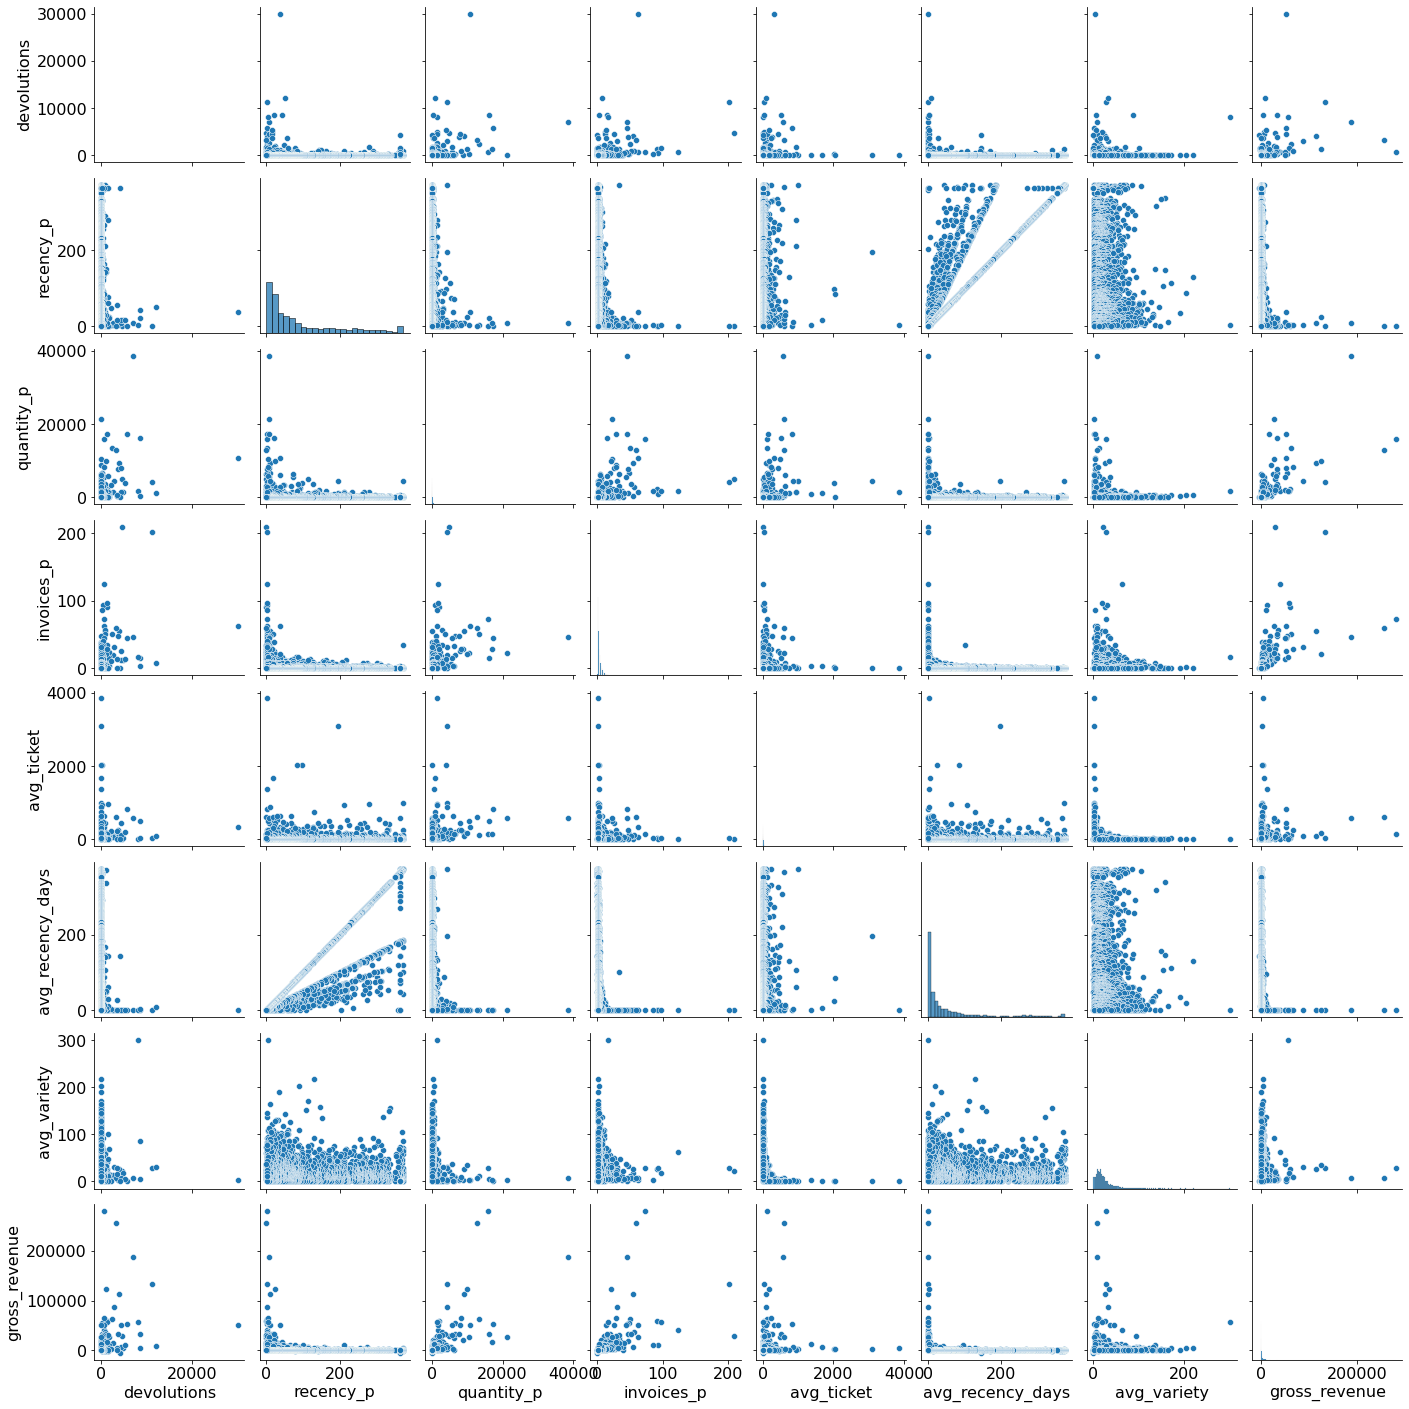

In [42]:
cols = ['customer_id', 'purchases', 'recency_d', 'quantity_d', 'invoices_d', 'avg_basket_size', 'purchases_pday','relative_revenue', 'relative_quantity']
df_bivariate = df4.drop(cols, axis=1)


fig = plt.figure(figsize=(25,12))
sns.pairplot(df_bivariate)
plt.savefig('bivariate.png', dpi=fig.dpi)
plt.show()

## 4.3. Data space analysis

In some cases, it is possible to transform the data dimensionality of one space into another, trough embedding techniques. in the next snippets we will try to answer the following question: **are our customers better clusterized in a embedded space?**

To answer the question we will use 3 different techniques:
- **PCA**: Primary Component Analysis;
- **UMAP**: Uniform Manifold Approximation and Projection for Dimension Reduction;
- **Tree-based embedding**: consists of using the predictions of a Random Forest model to create a larger space of features and, then, reducing it (using UMAP).

In [43]:
data_space = df4.copy()
customers_to_cluster = data_space.loc[:,'customer_id'].to_list()
print(data_space.isna().sum())
data_space = data_space.drop(columns=['customer_id', 'gross_revenue', 'recency_d', 'quantity_d', 'invoices_d', 'avg_basket_size', 'purchases_pday','relative_revenue', 'relative_quantity'], axis=1)
#data_space = data_space.drop(columns=['customer_id', 'purchases', 'recency_d', 'quantity_d', 'invoices_p', 'invoices_d', 'avg_basket_size', 'purchases_pday','relative_revenue', 'relative_quantity'], axis=1)
print('Used columns for data space analysis: {}'.format(data_space.columns))

rs = RobustScaler()
mm = MinMaxScaler()
ss = StandardScaler()

data_space['purchases'] = np.log1p(data_space['purchases']) #mm.fit_transform( data_space[['purchases']].values )
data_space['devolutions'] = np.log1p(data_space['devolutions'])  #mm.fit_transform( data_space[['devolutions']].values )
#data_space['purc_dev'] = rs.fit_transform( data_space[['purc_dev']].values )
data_space['recency_p'] = np.log1p(data_space['recency_p']) #rs.fit_transform( data_space[['recency_p']].values )
#data_space['recency_d'] = rs.fit_transform( data_space[['recency_d']].values )
data_space['quantity_p'] = np.log1p(data_space['quantity_p']) #mm.fit_transform( data_space[['quantity_p']].values )
#data_space['quantity_d'] = mm.fit_transform( data_space[['quantity_d']].values )
data_space['invoices_p'] = np.log1p(data_space['invoices_p']) #rs.fit_transform( data_space[['invoices_p']].values )
#data_space['invoices_d'] = rs.fit_transform( data_space[['invoices_d']].values )

#data_space['gross_revenue'] = mm.fit_transform( data_space[['gross_revenue']].values )
data_space['avg_ticket'] = np.log1p(data_space['avg_ticket']) #mm.fit_transform( data_space[['avg_ticket']].values )
data_space['avg_recency_days'] = np.log1p(data_space['avg_recency_days']) #rs.fit_transform( data_space[['avg_recency_days']].values )
data_space['avg_variety'] = np.log1p(data_space['avg_variety']) #rs.fit_transform( data_space[['avg_variety']].values )
#data_space['avg_variety'] = rs.fit_transform( data_space[['avg_variety']].values )
#data_space['relative_quantity'] = rs.fit_transform( data_space[['relative_quantity']].values )
#data_space['relative_invoices'] = rs.fit_transform( data_space[['relative_invoices']].values )
#data_space['purchases_pday'] = rs.fit_transform( data_space[['purchases_pday']].values )

#data_space['monetary_score'] = ss.fit_transform( data_space[['ticket_score']].values )
#data_space['ticket_score'] = ss.fit_transform( data_space[['ticket_score']].values )
#data_space['recency_score'] = ss.fit_transform( data_space[['recency_score']].values )
#data_space['behavior_score'] = ss.fit_transform( data_space[['behavior_score']].values )

customer_id          0
purchases            0
devolutions          0
recency_p            0
recency_d            0
quantity_p           0
quantity_d           0
invoices_p           0
invoices_d           0
avg_ticket           0
avg_recency_days     0
avg_basket_size      0
avg_variety          0
purchases_pday       0
gross_revenue        0
relative_revenue     0
relative_quantity    0
dtype: int64
Used columns for data space analysis: Index(['purchases', 'devolutions', 'recency_p', 'quantity_p', 'invoices_p',
       'avg_ticket', 'avg_recency_days', 'avg_variety'],
      dtype='object')


In [44]:
data_space.describe()

,purchases,devolutions,recency_p,quantity_p,invoices_p,avg_ticket,avg_recency_days,avg_variety
count,4.362000e+03,4.362000e+03,4.362000e+03,4.362000e+03,4.362000e+03,4.362000e+03,4.362000e+03,4.362000e+03
mean,6.539559e+00,1.327275e+00,3.815426e+00,4.755419e+00,1.335756e+00,2.953632e+00,2.984989e+00,2.810477e+00
std,1.370905e+00,1.968200e+00,1.389389e+00,1.193426e+00,6.910012e-01,8.666027e-01,1.723707e+00,8.536970e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.717381e+00,0.000000e+00,2.890372e+00,4.110874e+00,6.931472e-01,2.563748e+00,1.558145e+00,2.322388e+00
50%,6.500832e+00,0.000000e+00,3.951244e+00,4.753590e+00,1.098612e+00,2.926819e+00,3.006093e+00,2.888576e+00
75%,7.409528e+00,2.862201e+00,4.997212e+00,5.458519e+00,1.791759e+00,3.247925e+00,4.369448e+00,3.367296e+00
max,1.254328e+01,1.031006e+01,5.924256e+00,1.056204e+01,5.347108e+00,8.258940e+00,5.924256e+00,5.709258e+00


### 4.3.1. PCA - Principal Component Analysis

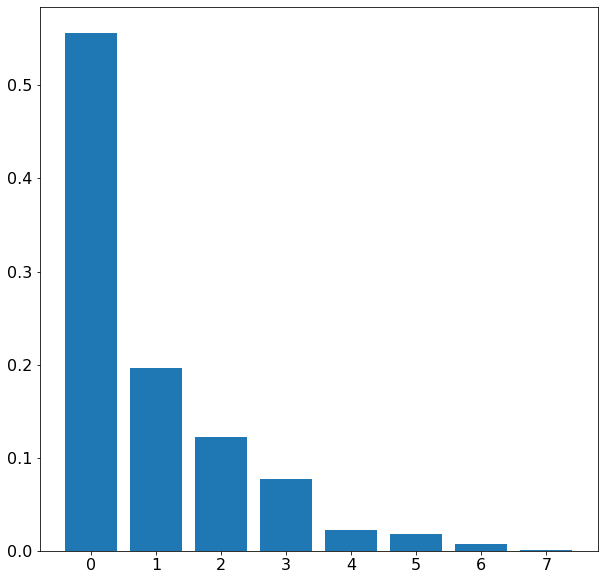

In [45]:
X_PCA = data_space.copy()
pca = decomposition.PCA(n_components=X_PCA.shape[1])

principal_component = pca.fit_transform(X_PCA)

features = range(pca.n_components_)

fig = plt.figure(figsize=(10,10))
plt.bar(features, pca.explained_variance_ratio_)
plt.savefig('pca.png', dpi=fig.dpi)
plt.show()

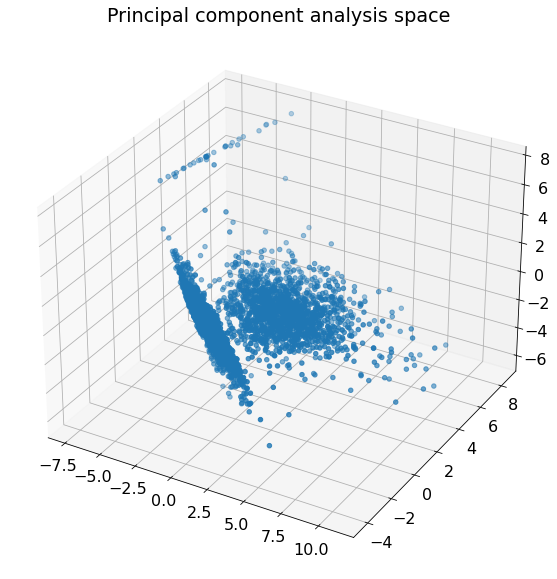

In [46]:
df_pca = pd.DataFrame(principal_component)

#plt.figure(figsize=(10,10))
#sns.scatterplot(x=0, y=1, data=df_pca)
#plt.show()

plot_embedded_space(df_pca, principal_component, 3, 'Principal component analysis space', fig_name='pca_embed.png')


### 4.3.2. UMAP

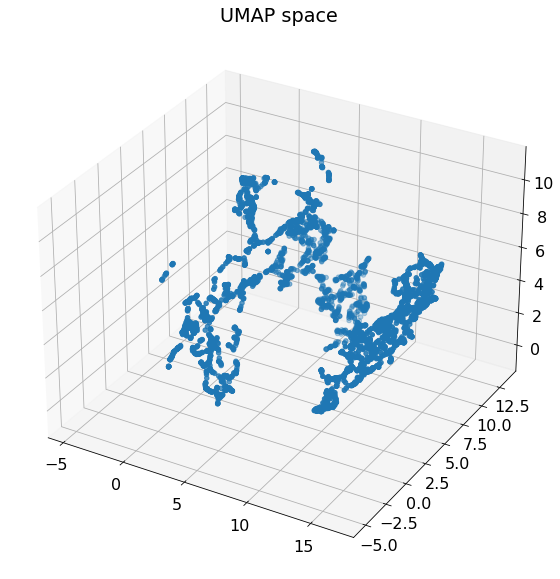

In [47]:
X_UMAP = data_space.copy()
reducer = ump.UMAP(random_state=42, n_components=3, n_neighbors=4, min_dist=0.025, metric='cosine')
embedding = reducer.fit_transform(X_UMAP)

plot_embedded_space(X_UMAP, embedding, 3, 'UMAP space', fig_name='umap_embed.png')


### 4.3.3. t-SNE

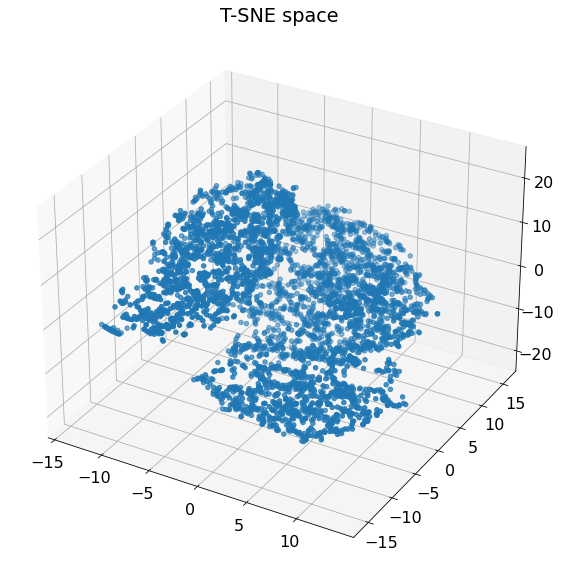

In [48]:
X_TSNE = data_space.copy()
reducer = TSNE( random_state=42, n_components=3)
embedding = reducer.fit_transform(X_TSNE)

plot_embedded_space(X_TSNE, embedding, 3, 'T-SNE space', fig_name='tsne_embed.png')


### 4.3.3. Tree-based embedding

The tree-based space has the following dimensions: (4362, 250)


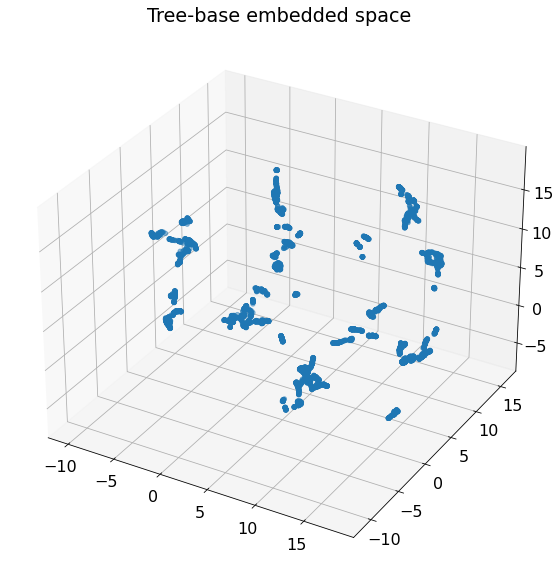

The tree-based space has the following dimensions after using UMAP: (4362, 253) 
 Notice that that only the last 3 features will remain


In [49]:
# training dataset
x_trees = data_space.drop(columns=['purchases'], axis=1)
y_trees = data_space['purchases']

#model definition
rf_model = RandomForestRegressor(n_estimators=250, random_state=42)

# model training
rf_model.fit(x_trees, y_trees)

#Leaves
df_leaf = pd.DataFrame(rf_model.apply(x_trees))

#Leaves dataFrame
print('The tree-based space has the following dimensions: {}'.format(df_leaf.shape))

n_components=3

reducer = ump.UMAP( random_state=42, n_components=n_components, n_neighbors=15 )
embedding = reducer.fit_transform(df_leaf)

#df_leaf['embedding_x'] = embedding[:,0]
#df_leaf['embedding_y'] = embedding[:,1]
#df_leaf['embedding_z'] = embedding[:,2]

plot_embedded_space(df_leaf, embedding, n_components, 'Tree-base embedded space', fig_name='tree_embed.png')

print('The tree-based space has the following dimensions after using UMAP: {} \n Notice that that only the last 3 features will remain'.format(df_leaf.shape))


With the results of the embedded space, it is possible to clearly see different clusters of customers, making the approach of a tree-based space promising for customers clusterization.

# 5. Data preparation

**Rules of thumb**

Standardization -> assumption that the feature follows a normal distribution (test for normal distribution QQ Plot or KS Test)
Rescale         -> assumption that the feature does not follow a normal distribution

**Based on features:**
1. Normal distribution and abscence of outliers -> Standard scaler;
2. Normal distribution and have outliers        -> Robust scaler;
3. Does not follow a normal distribution        -> Min-max scaler;

## 5.1. Data rescaling

In [50]:
df_rescaled = df4.copy()
#df_rescaled = data_space.copy()
df_rescaled = df_rescaled.drop(columns=['customer_id', 'gross_revenue', 'recency_d', 'quantity_d', 'invoices_d', 'avg_basket_size', 'purchases_pday','relative_revenue', 'relative_quantity'], axis=1)
#df_rescaled = df_rescaled.drop(columns=['customer_id', 'purchases', 'recency_d', 'quantity_d', 'invoices_p', 'invoices_d', 'avg_basket_size', 'purchases_pday','relative_revenue', 'relative_quantity'], axis=1)

rs = RobustScaler()
mm = MinMaxScaler()
ss = StandardScaler()

In [51]:
df_rescaled['purchases'] = np.log1p(df_rescaled['purchases']) #mm.fit_transform( df_rescaled[['purchases']].values )
df_rescaled['devolutions'] = np.log1p(df_rescaled['devolutions'])  #mm.fit_transform( df_rescaled[['devolutions']].values )
#df_rescaled['purc_dev'] = rs.fit_transform( df_rescaled[['purc_dev']].values )
df_rescaled['recency_p'] = np.log1p(df_rescaled['recency_p']) #rs.fit_transform( df_rescaled[['recency_p']].values )
#df_rescaled['recency_d'] = rs.fit_transform( df_rescaled[['recency_d']].values )
df_rescaled['quantity_p'] = np.log1p(df_rescaled['quantity_p']) #mm.fit_transform( df_rescaled[['quantity_p']].values )
#df_rescaled['quantity_d'] = mm.fit_transform( df_rescaled[['quantity_d']].values )
df_rescaled['invoices_p'] = np.log1p(df_rescaled['invoices_p']) #rs.fit_transform( df_rescaled[['invoices_p']].values )
#df_rescaled['invoices_d'] = rs.fit_transform( df_rescaled[['invoices_d']].values )

#df_rescaled['gross_revenue'] = mm.fit_transform( df_rescaled[['gross_revenue']].values )
df_rescaled['avg_ticket'] = np.log1p(df_rescaled['avg_ticket']) #mm.fit_transform( df_rescaled[['avg_ticket']].values )
df_rescaled['avg_recency_days'] = np.log1p(df_rescaled['avg_recency_days']) #rs.fit_transform( df_rescaled[['avg_recency_days']].values )
df_rescaled['avg_variety'] = np.log1p(df_rescaled['avg_variety']) #rs.fit_transform( df_rescaled[['avg_variety']].values )
#df_rescaled['avg_variety'] = rs.fit_transform( df_rescaled[['avg_variety']].values )
#df_rescaled['relative_quantity'] = rs.fit_transform( df_rescaled[['relative_quantity']].values )
#df_rescaled['relative_invoices'] = rs.fit_transform( df_rescaled[['relative_invoices']].values )
#df_rescaled['purchases_pday'] = rs.fit_transform( df_rescaled[['purchases_pday']].values )

#df_rescaled['monetary_score'] = ss.fit_transform( df_rescaled[['ticket_score']].values )
#df_rescaled['ticket_score'] = ss.fit_transform( df_rescaled[['ticket_score']].values )
#df_rescaled['recency_score'] = ss.fit_transform( df_rescaled[['recency_score']].values )
#df_rescaled['behavior_score'] = ss.fit_transform( df_rescaled[['behavior_score']].values )

In [52]:
df_rescaled.describe()

,purchases,devolutions,recency_p,quantity_p,invoices_p,avg_ticket,avg_recency_days,avg_variety
count,4.362000e+03,4.362000e+03,4.362000e+03,4.362000e+03,4.362000e+03,4.362000e+03,4.362000e+03,4.362000e+03
mean,6.539559e+00,1.327275e+00,3.815426e+00,4.755419e+00,1.335756e+00,2.953632e+00,2.984989e+00,2.810477e+00
std,1.370905e+00,1.968200e+00,1.389389e+00,1.193426e+00,6.910012e-01,8.666027e-01,1.723707e+00,8.536970e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.717381e+00,0.000000e+00,2.890372e+00,4.110874e+00,6.931472e-01,2.563748e+00,1.558145e+00,2.322388e+00
50%,6.500832e+00,0.000000e+00,3.951244e+00,4.753590e+00,1.098612e+00,2.926819e+00,3.006093e+00,2.888576e+00
75%,7.409528e+00,2.862201e+00,4.997212e+00,5.458519e+00,1.791759e+00,3.247925e+00,4.369448e+00,3.367296e+00
max,1.254328e+01,1.031006e+01,5.924256e+00,1.056204e+01,5.347108e+00,8.258940e+00,5.924256e+00,5.709258e+00


# 6. Feature selection

Despite the fact that many features were created, the number of features used for clusterization are only the ones that were rescaled. The main goal of this reduction is to use features more tangible and related to the business.
- **devolutions**: financial value subtracted to the company due to devolution of a product;
- **recency_p**: days between today and the last purchase made by the customer;
- **quantity_p**: number of product bought by a customer in a single invoice;
- **gross_revenue**: financial value received by the company due to the purchase of items by the customer;
- **avg_ticket**: gross_revenue divided by the number of invoices, meaning the average expenditure of a customer for each invoice
- **avg_recency_days**: mean time in days between purchases made by the customer;
- **avg_variety**: mean value of different items in a basket per invoice per customer.

Those features were used to train a Random Forest Regressor used to predict the gross_revenue of each customer, then UMAP were used to embed the Random Forest model in 3 dimensions. Finally, those dimensions will be use to cluster the customers.

# 7. Hyperparameter fine tuning

There are 3 types of major problems within data problems to solve with machine learning algorithms: regression, classification and clusterization. The first two problems, regression and classification, there is a necessity to split the dataset between training and testing and there is a target variable to analyze the accuracy and precision of the model, while the clusterization problems does not have the need in dataset spliting. Because of that, there is a necessity to first determine the number of clusters which the dataset will be split, before training and finding the model.

Here, it is important to say that **different models (K-Means, Gaussian Mixture Model and Hierarchical) were tested both in embedded space and not embedded space and the best results were achieved with Hierarchical model in embedded space**.

In [53]:
df7 = df_rescaled.copy()
df7_embbed = X_UMAP.copy()

Before starting the comparison between models and spaces performances, it is necessery to drop all features from the tree-based space deriving from the estimators, leaving only the features created by embedding the space (along the directions x, y and z).

In [54]:
# Creating a list with all features of embedded space to drop
tree_cols_to_drop = []
for i in range( 0, (df7_embbed.shape[1]-4),1 ):
    tree_cols_to_drop.append(i)
    i = i + 1

# Saving a list of customers to cluster    
#customers_to_cluster = df4['customer_id'].to_list()    

# Dropping useless data in the embedded space
#X_embbed = df7_embbed.drop(columns=tree_cols_to_drop, axis=1)
X_embbed = df7_embbed.drop(columns=['purchases', 'devolutions', 'recency_p', 'quantity_p', 'invoices_p', 'avg_ticket', 'avg_recency_days', 'avg_variety'], axis=1)
#X_embbed = df7_embbed.drop(columns=[4, 5, 6, 'embedding_x', 'embedding_y', 'embedding_z'], axis=1)
#X_embbed = df7_embbed.copy()

# Dropping useless data
X = df7.copy()

## 7.1. K-Means

First model to be tested is the K-Means model. The model is very simple and consists of main a single hyperparameter k, which is the number of clusters to generate.

The model starts by creating k random initialized points in feature space, with each interaction, the distance of the k points, also called centroids, and other points are calculated. If the distance of a point P and centroid A is smaller than the distance of centroid B, then point P belongs to cluster A. Many iterations are made and, with each iteration, the average distance of a centroid C is reduced, by bringing the centroid closer to the points that belong to them.

### 7.1.1 K-Means on rescaled data

In [55]:
clusters = [2, 3, 4, 5, 6, 8, 10, 12, 14, 16, 18, 20]
dist_metric = 'cosine'

# Creating a list to store clustering metrics
kmeans_list =[]

for k in clusters:
    # model definition
    kmeans_model = cluster.KMeans(init='random', n_clusters=k, n_init=10, max_iter=100, random_state=42)

    # model training
    kmeans_model.fit(X)

    # model predict
    labels = kmeans_model.predict(X)

    # model performance
    sil = metrics.silhouette_score(X, labels, metric=dist_metric)
    kmeans_list.append(sil)

### 7.1.2. K-Means on embedded data

In [56]:
# Creating a list to store clustering metrics
kmeans_emb_list =[]

for k in clusters:
    # model definition
    kmeans_emb_model = cluster.KMeans(init='random', n_clusters=k, n_init=10, max_iter=100, random_state=42)

    # model training
    kmeans_emb_model.fit(X_embbed)

    # model predict
    labels = kmeans_emb_model.predict(X_embbed)

    # model performance
    sil = metrics.silhouette_score(X_embbed, labels, metric=dist_metric)
    kmeans_emb_list.append(sil)

## 7.2. Gaussian Mixture Model (GMM)

The K-Means model is a rigid model, which means that if a point P has a distance of 1 to cluster A and a distance of 1.01 to cluster B, point P will be assigned as belonging to cluster A.

The Gaussian Mixture Model comes to solve this problem with a more flexible approach, by allowing a point to have a probability of belonging to cluster A and a probability to B. It is done by considering that each cluster is a mixture of a gaussian distribution, having different parameters such a mean, covariance and probability of a point to belong to the cluster. This allows the model to form ellipsoid-like cluster structures to conform the data distribution.

### 7.2.1. Gaussian Mixture Model on rescaled data

In [57]:
# Creating a list to store clustering metrics
gmm_list =[]

for k in clusters:
    # model definition
    gmm_model = mx.GaussianMixture(n_components=k, max_iter=500, n_init=50)

    # model training
    gmm_model.fit(X)

    # model predict
    labels = gmm_model.predict(X)

    # model performance
    sil = metrics.silhouette_score(X, labels, metric=dist_metric)
    gmm_list.append(sil)

### 7.2.2. Gaussian Mixture Model on embedded data

In [58]:
# Creating a list to store clustering metrics
gmm_emb_list =[]

for k in clusters:
    # model definition
    gmm_emb_model = mx.GaussianMixture(n_components=k, max_iter=500, n_init=50)

    # model training
    gmm_emb_model.fit(X_embbed)

    # model predict
    labels = gmm_emb_model.predict(X_embbed)

    # model performance
    sil = metrics.silhouette_score(X_embbed, labels, metric=dist_metric)
    gmm_emb_list.append(sil)

## 7.3. Hierarchical Clustering

In contrast to the other clustering models, the hierarchical model have a more bottom-up strategy. It begins by considering each point a cluster. Then, it will measure the distances between the clusters following one criteria (within the options: **ward, complete, single, average, centroid, weighted**) and cluster the closest points, creating clusters of up to 2 points, measure the distances again, and cluster the closest clusters together. The process of clustering keeps happening until a single cluster with all points is made.

### 7.3.1. Hierarchical clustering on rescaled data

In [59]:
# Creating a list to store clustering metrics
hc_list =[]

for k in clusters:
    # model definition & training
    hc_model = hc.linkage(X, 'average')

    # model predict
    labels = hc.fcluster(hc_model, k, criterion='maxclust')

    # model performance
    sil = metrics.silhouette_score(X, labels, metric=dist_metric)
    hc_list.append(sil)

### 7.3.2. Hierarchical clustering on embedded data

In [60]:
# Creating a list to store clustering metrics
hc_emb_list =[]

for k in clusters:
    # model definition & training
    hc_emb_model = hc.linkage(X_embbed, 'average')

    # model predict
    labels = hc.fcluster(hc_emb_model, k, criterion='maxclust')

    # model performance
    sil = metrics.silhouette_score(X_embbed, labels, metric=dist_metric)
    hc_emb_list.append(sil)

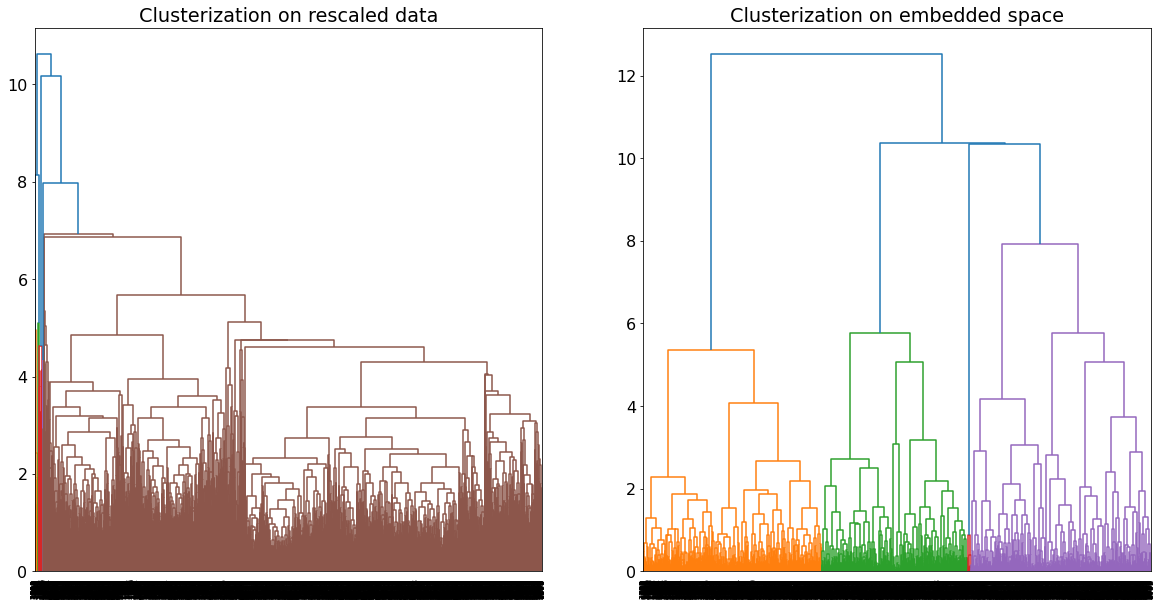

In [61]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

hc1 = hc.dendrogram(
        hc_model,
        leaf_rotation=90,
        leaf_font_size=8,
        ax=axes[0]
        )

hc2 = hc.dendrogram(
        hc_emb_model,
        leaf_rotation=90,
        leaf_font_size=8,
        ax=axes[1]
        )

axes[0].set_title('Clusterization on rescaled data')
axes[1].set_title('Clusterization on embedded space')
plt.plot()
plt.savefig('hierarchical.png', dpi=fig.dpi)
plt.show()

## 7.4. Clustering metrics evaluation

Clustering problems in data science do not have a target variable, which means that the clustering error and precision depends on the analyst's input (or hyperparameters used). In order to reduce the subjectiviy of the analyst's choice, there are some metrics to evaluate how many cluster the datset must be divided. Two metrics are the **within-cluster sum of square (WSS)** or the **sillhouette score**.

For further analysis between models and spaces of features, we will compare only the **Silhouette Score**. A simple explanation of the metric and its meaning is given below.

**Silhouette score meaning**: measure how distant the clusters are between each other and how compact one cluster is. The metric can be interpretated by analyzing the values of the distances. For a positive score, with maximum value of 1, it means that the clusters are compact and distant from each other, however the closest to -1 means that the clusters are large and/or overlapping.

In [62]:
df_results = pd.DataFrame(
    {'KMeans': kmeans_list,
     'KMeans_Embed': kmeans_emb_list,
    'GMM': gmm_list,
    'GMM_Embed': gmm_emb_list,
    'Hierarchical': hc_list,
    'Hierarchical_Embed': hc_emb_list}
    ).T

df_results.columns = clusters

display(df_results.style.highlight_max(color='lightgreen', axis=1))

,2,3,4,5,6,8,10,12,14,16,18,20
KMeans,0.545180,0.479899,0.488782,0.410403,0.438433,0.307073,0.301620,0.252494,0.210702,0.203942,0.195431,0.170897
KMeans_Embed,0.358958,0.585818,0.628414,0.517795,0.529249,0.582143,0.520360,0.487446,0.506563,0.463432,0.342023,0.306616
GMM,0.477340,0.436043,0.307594,0.355928,0.142873,0.047152,0.040926,0.035273,-0.001869,-0.029695,0.001195,0.003413
GMM_Embed,0.358958,0.578215,0.622638,0.532195,0.671000,0.586795,0.392587,0.330340,0.310614,0.414156,0.323409,0.316584
Hierarchical,0.818062,0.359126,0.332487,0.196029,0.116511,0.258365,0.106298,0.083905,0.170654,0.127494,0.114399,-0.129866
Hierarchical_Embed,0.358958,0.584228,0.607491,0.677683,0.644412,0.581609,0.493947,0.542784,0.447327,0.403551,0.409265,0.372144


Despite the fact that different models have a higher performance with 5 or less clusters, the model chosen is the GMM with embedded UMAP space and 8 clusters. The main reason for this choice is to keep both a good metric value (~ 0.615 for SS) and less customers per cluster, in order to assure that the purpose of choosing only the best customers as Insiders.

# 8. Model training

## 8.1. Gaussian Mixture Model

In [63]:
k = 8

# model definition
try:
    parameters = json.load('models/model_parameters.json')
    gmm_emb_model = mx.GaussianMixture(n_components=k, max_iter=500, n_init=100, random_state=42,
                                       weights_init = np.array(parameters['weights']),
                                       means_init = np.array(parameters['means']),
                                       precisions_init = np.array(parameters['precisions'])
                                      )
    
except:
    print('Tried loading previous model parameters, but without sucess.')
    gmm_emb_model = mx.GaussianMixture(n_components=k, max_iter=500, n_init=100, random_state=42)

# model training
gmm_emb_model.fit(X_embbed)

# model predict
labels = gmm_emb_model.predict(X_embbed)

# model performance
#sil = metrics.silhouette_score(X_embbed, labels, metric='euclidean')

#labels = gmm_emb_model.labels_


# model definition & training
#hc_emb_model = hc.linkage(X_embbed, 'average')

# model predict
#labels = hc.fcluster(hc_emb_model, k, criterion='maxclust')

# model performance
#sil = metrics.silhouette_score(X_embbed, labels, metric='euclidean')

Tried loading previous model parameters, but without sucess.


Since Gaussian Mixture Model depends on the initial points to define the clusters, we will store our model results in a dictionary for futher use.

In [64]:
model_parameters = {
    'weights':gmm_emb_model.weights_.tolist(),
    'means': gmm_emb_model.means_.tolist(),
    'covariance': gmm_emb_model.covariances_.tolist(),
    'precisions': gmm_emb_model.precisions_.tolist(),
    'converged': gmm_emb_model.converged_
}

with open('models/model_parameters.json', 'w') as fp:
    json.dump(model_parameters, fp)

# 9. Cluster analysis

## 9.1. Final model

In [65]:
df9 = df_ref.copy()
df9 = df9[df9['customer_id'].isin(customers_to_cluster)]
df9['cluster'] = labels
X_UMAP['cluster'] = labels

### 9.1.1. Visualization Inspection

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


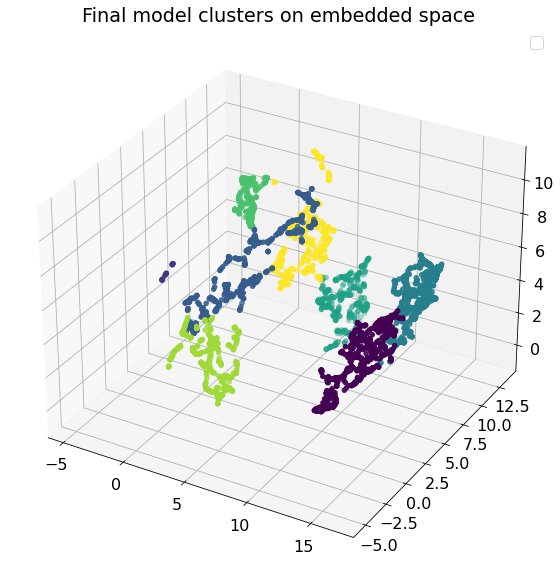

In [66]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_UMAP['embedding_x'], X_UMAP['embedding_y'], X_UMAP['embedding_z'], c=X_UMAP['cluster'])


ax.set_title('Final model clusters on embedded space')
ax.legend()
plt.savefig('clusters.png', dpi=fig.dpi)
plt.show()

### 9.1.4. Cluster profile

The profile of each cluster can be represented as a persona, and the persona is the mean or median behavior of all other customers inside the cluster

In [67]:
df_cluster = df9[['customer_id','cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = round(100*(df_cluster['customer_id'] / df_cluster['customer_id'].sum()), 3)

df_purchases = round(df9[['purchases', 'cluster']].groupby('cluster').mean().reset_index(), 2)
df_avg_devolutions = round(df9[['devolutions', 'cluster']].groupby('cluster').mean().reset_index(), 2)
#df_avg_relation = round(df9[['purc_dev','cluster']].groupby('cluster').mean().reset_index() , 2)

df_avg_recency_p = round(df9[['cluster', 'recency_p']].groupby('cluster').mean().reset_index(), 2)
#df_avg_quantity_d = round(df9[['cluster', 'quantity_d']].groupby('cluster').mean().reset_index(), 2)

df_frequency_p = round(df9[['cluster', 'invoices_p']].groupby('cluster').mean().reset_index(), 2)

df_quantity_p = round(df9[['cluster','quantity_p']].groupby('cluster').mean().reset_index(), 2)
#df_avg_frequency_d = round(df9[['cluster','quantity_d']].groupby('cluster').mean().reset_index(), 2)

df_avg_ticket = round(df9[['cluster','avg_ticket']].groupby('cluster').mean().reset_index(), 2)
df_avg_recency_days = round(df9[['cluster','avg_recency_days']].groupby('cluster').mean().reset_index(), 2)
df_avg_variety = round(df9[['cluster','avg_variety']].groupby('cluster').mean().reset_index(), 2)

df_cluster = pd.merge(df_cluster, df_purchases, on='cluster', how='inner')
df_cluster = pd.merge(df_cluster, df_avg_devolutions, on='cluster', how='inner')
#df_cluster = pd.merge(df_cluster, df_avg_relation, on='cluster', how='inner')
df_cluster = pd.merge(df_cluster, df_avg_recency_p, on='cluster', how='inner')
df_cluster = pd.merge(df_cluster, df_frequency_p, on='cluster', how='inner')
df_cluster = pd.merge(df_cluster, df_quantity_p, on='cluster', how='inner')
#df_cluster = pd.merge(df_cluster, df_avg_frequency_d, on='cluster', how='inner')
df_cluster = pd.merge(df_cluster, df_avg_ticket, on='cluster', how='inner')
df_cluster = pd.merge(df_cluster, df_avg_recency_days, on='cluster', how='inner')
df_cluster = pd.merge(df_cluster, df_avg_variety, on='cluster', how='inner')

df_cluster

,cluster,customer_id,perc_customer,purchases,devolutions,recency_p,invoices_p,quantity_p,avg_ticket,avg_recency_days,avg_variety
0,0,824,1.889000e+01,1.333790e+03,8.930000e+01,1.091500e+02,3.340000e+00,1.899400e+02,3.255000e+01,3.629000e+01,2.201000e+01
1,1,33,7.570000e-01,0.000000e+00,3.154900e+02,3.650000e+02,0.000000e+00,0.000000e+00,0.000000e+00,2.859200e+02,0.000000e+00
2,2,696,1.595600e+01,4.394600e+02,0.000000e+00,1.049500e+02,1.020000e+00,1.257800e+02,2.100000e+01,1.049500e+02,2.800000e+01
3,3,711,1.630000e+01,7.265470e+03,3.085500e+02,1.255000e+01,1.231000e+01,7.790100e+02,3.515000e+01,1.450000e+00,2.277000e+01
4,4,598,1.370900e+01,1.759640e+03,1.000000e-02,1.337000e+01,5.150000e+00,2.859800e+02,3.062000e+01,3.660000e+00,2.842000e+01
5,5,331,7.588000e+00,4.851100e+02,1.000000e-02,1.514600e+02,2.060000e+00,8.094000e+01,1.651000e+01,7.890000e+01,2.093000e+01
6,6,506,1.160000e+01,1.995600e+02,2.000000e-02,2.499000e+02,1.040000e+00,6.472000e+01,4.263000e+01,2.470300e+02,1.213000e+01
7,7,663,1.519900e+01,1.045040e+03,3.000000e-02,6.254000e+01,3.040000e+00,2.544000e+02,5.061000e+01,2.364000e+01,1.848000e+01


# 10. Clusters insights

In [68]:
df10 = df9.copy()

## Hypothesis for insights

1. Affirmation
2. Features comparison or clusters comparison
3. Base value for comparison and classification in true or false for each hypothesis

Example: Cluster | Feature analyzed | Base value for comparison

### Purchase hypothesis

1. More than 80% of Insiders customers use credit card for payment
2. **Insiders clusters have an average ticket of at least 10% higher than any other cluster**
3. Insiders customers have a basket size higher than 5 products
4. **Insiders customers have a contribution of at least 10% of the total purchases**
5. **Insiders customers have a smaller proportion of devolutions than the average of all customers**

### Client hypothesis

1. 60% of Insiders customers are single
2. 10% of Insiders customers are aged between 24 - 35 years old
3. 40% of Insiders customers are located in a radius of 50 km
4. 5%  of Insiders customers earn a salary higher than USD 100.000 yearly
5. 90% of Insiders customers have a high education degree

### Product hypothesis

1. **30% of the all products are bought by Insiders customers.**
2. Insiders customers buys more variety of products.
3. **Insiders customers buys products with a higher unit price than other customers.**

### Purchase H2. The median of revenues from insiders customers is 10% higher than the median of other customers

In [69]:
insiders_gnv_median = df10.loc[df10['cluster']== 3, 'gross_revenue'].median()
total_gnv_median = df10.loc[:,'gross_revenue'].median()

revenue_diff_median = (insiders_gnv_median - total_gnv_median) / total_gnv_median

print('Insiders revenue median is {}% higher than the median revenue'.format(round(revenue_diff_median*100, 2)))

Insiders revenue median is 353.26% higher than the median revenue


### Purchase H4. Insiders have a contribution of at least 10% of total purchases

In [70]:
insiders_purchases = df10.loc[df10['cluster'] == 3, 'purchases'].sum()
total_purchases = df10['purchases'].sum()

print('Insiders have a contribution of {}% of total purchases'.format(100 * round(insiders_purchases/total_purchases, 4)))

Insiders have a contribution of 60.23% of total purchases


### Purchase H5. Insiders have a smaller proportion of devolution than the average of all customers

In [71]:
# The proportion is valid only for customers with at least a purchase
devolutions_proportion = df10.loc[df10['purchases'] > 0 , ['customer_id', 'devolutions', 'cluster', 'purchases']]

devolutions_proportion['proportion'] = devolutions_proportion['devolutions'] / devolutions_proportion['purchases']

print('Insiders proportion of devolutions per purchases is {}%, while the proportion for other customers is {}%'
      .format( 
          round(100*devolutions_proportion.loc[devolutions_proportion['cluster'] == 3, 'proportion'].mean(), 3),
          round(100*devolutions_proportion.loc[devolutions_proportion['cluster'] != 3, 'proportion'].mean(), 3)
      ))

Insiders proportion of devolutions per purchases is 4.412%, while the proportion for other customers is 3.793%


### Product H1. 30% of all products are bought by Insiders customers

In [72]:
insiders_quantity = df10.loc[df10['cluster'] == 3, 'quantity_p'].sum()
total_quantity = df10['quantity_p'].sum()

print('Insiders have a contribution of {}% of total itens bought'.format(100 * round(insiders_quantity/total_quantity, 4)))

Insiders have a contribution of 46.27% of total itens bought


### Product H3. Insiders customers buys products with a higher unit price than other customers

In [73]:
unit_price = df10.loc[df10['quantity_p'] > 0 , ['customer_id', 'quantity_p', 'cluster', 'purchases']]

unit_price['avg_unit_price'] = unit_price['purchases'] / unit_price['quantity_p']

print('Insiders have an average unit price of ${}, while other customers have an average of ${}'.format( 
          round(unit_price.loc[unit_price['cluster'] == 3, 'avg_unit_price'].mean(), 3),
          round(unit_price.loc[unit_price['cluster'] != 3, 'avg_unit_price'].mean(), 2)
      ))

Insiders have an average unit price of $13.01, while other customers have an average of $8.48


## 10.1. Business questions

### 1. Who are electible to participate in the Insiders program?

In [74]:
insiders_customers = df10.loc[df10['cluster'] == 3, 'customer_id'].tolist()

### 2. How many customers will be part of the group?

In [75]:
print('The total number of Insiders customers is: {}'.format(df10.loc[df10['cluster'] == 3, 'customer_id'].size))

The total number of Insiders customers is: 711


### 3. What are the main characteristic of those customers?

Main characteristic of Insiders customers:
- Gross revenue: \\$7265.47;
- Returns: \\$308.55;
- Recency of last purchase: 12.55 days;
- Number of orders: 12.31 orders;
- Quantity of products bought per order: 779 products;
- Average ticket: \\$35.15;
- Average time between purchases: 1.45 days;
- Average variety of products purchased: 22.77.

### 4. What are the contribution of those customers in revenue?

In [76]:
insiders_total_revenue = df10.loc[df10['cluster'] == 3, 'gross_revenue'].sum()
all_total_revenue = df10.loc[:, 'gross_revenue'].sum()

print('Insiders contribution in gross revenue is {}% of total revenue'.format(round(insiders_total_revenue*100 / all_total_revenue, 2)))

Insiders contribution in gross revenue is 59.78% of total revenue


### 5. What are the future expectations for revenue in the next months for these customers?

In [77]:
df_cluster

,cluster,customer_id,perc_customer,purchases,devolutions,recency_p,invoices_p,quantity_p,avg_ticket,avg_recency_days,avg_variety
0,0,824,1.889000e+01,1.333790e+03,8.930000e+01,1.091500e+02,3.340000e+00,1.899400e+02,3.255000e+01,3.629000e+01,2.201000e+01
1,1,33,7.570000e-01,0.000000e+00,3.154900e+02,3.650000e+02,0.000000e+00,0.000000e+00,0.000000e+00,2.859200e+02,0.000000e+00
2,2,696,1.595600e+01,4.394600e+02,0.000000e+00,1.049500e+02,1.020000e+00,1.257800e+02,2.100000e+01,1.049500e+02,2.800000e+01
3,3,711,1.630000e+01,7.265470e+03,3.085500e+02,1.255000e+01,1.231000e+01,7.790100e+02,3.515000e+01,1.450000e+00,2.277000e+01
4,4,598,1.370900e+01,1.759640e+03,1.000000e-02,1.337000e+01,5.150000e+00,2.859800e+02,3.062000e+01,3.660000e+00,2.842000e+01
5,5,331,7.588000e+00,4.851100e+02,1.000000e-02,1.514600e+02,2.060000e+00,8.094000e+01,1.651000e+01,7.890000e+01,2.093000e+01
6,6,506,1.160000e+01,1.995600e+02,2.000000e-02,2.499000e+02,1.040000e+00,6.472000e+01,4.263000e+01,2.470300e+02,1.213000e+01
7,7,663,1.519900e+01,1.045040e+03,3.000000e-02,6.254000e+01,3.040000e+00,2.544000e+02,5.061000e+01,2.364000e+01,1.848000e+01


### 6. What are the conditions for a person to be elected in the Insiders program?

Have the following conditions:
- Higher number of orders: above 10
- Higher average variety of products: above 20 different products per invoice
- Last purchase: last purchase under 20 days, and purchases under 5 days in average
- Quantity of items per invoice: above 500 units per invoice
- High invoice values: each purchase is above \\$2500

### 7. What are the conditions for a person to be removed from the Insiders program?

Looking for the differences between cluster 1 (Insiders) and the other clusters, it can be inferred that the main reason for a customer to be removed from the Insiders program is:
- If the last purchase rises above 30 days and the average time between purchases rises above 7 days;
- If the value of purchases of each invoice drops below \\$2500 in average;
- If the quantity of products bought drops to under 400 units.

### 8. How we can be sure that a Insider customer is better than the others customers?

A Insider customer buys more frequently (lower values from recency and average recency), buys more quantity and have higher tickets than other customers.

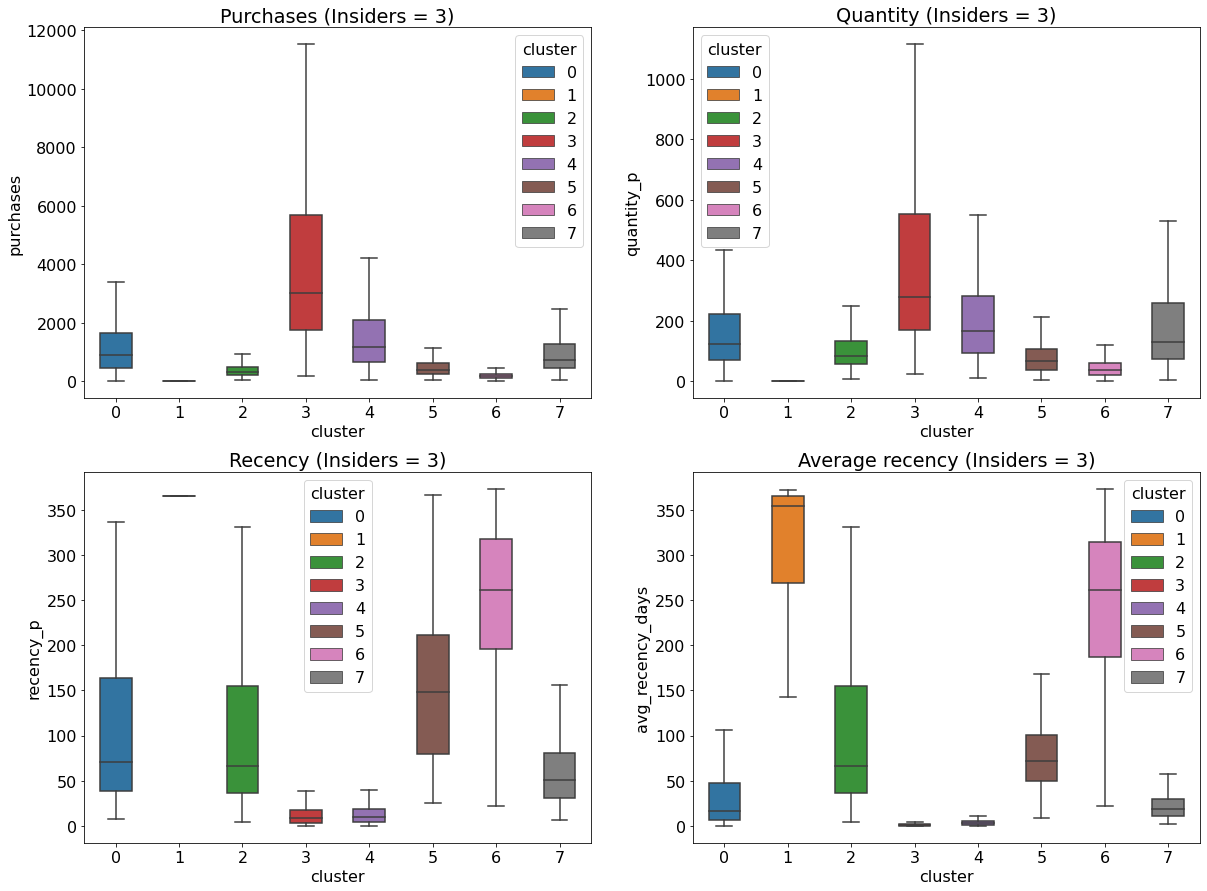

In [78]:
# Inserting graphs
fig = plt.figure(figsize=(20,15))

ax1 = fig.add_subplot(2,2,1)
sns.boxplot(data=df10, hue='cluster', y='purchases', x='cluster', width=0.5, order=[0, 1, 2, 3, 4, 5, 6, 7], dodge=False, autorange=True, showfliers=False)
ax1.set_title('Purchases (Insiders = 3)')

ax2 = fig.add_subplot(2,2,2)
sns.boxplot(data=df10, hue='cluster', y='quantity_p', x='cluster', width=0.5, order=[0, 1, 2, 3, 4, 5, 6, 7], dodge=False, autorange=True, showfliers=False)
ax2.set_title('Quantity (Insiders = 3)')

ax2 = fig.add_subplot(2,2,3)
sns.boxplot(data=df10, hue='cluster', y='recency_p', x='cluster', width=0.5, order=[0, 1, 2, 3, 4, 5, 6, 7], dodge=False, autorange=True, showfliers=False)
ax2.set_title('Recency (Insiders = 3)')

ax2 = fig.add_subplot(2,2,4)
sns.boxplot(data=df10, hue='cluster', y='avg_recency_days', x='cluster', width=0.5, order=[0, 1, 2, 3, 4, 5, 6, 7], dodge=False, autorange=True, showfliers=False)
ax2.set_title('Average recency (Insiders = 3)')

plt.savefig('boxplots.png', dpi=fig.dpi)

plt.show()

From the previous graphs we can see that:
- Insiders purchases higher invoices (cluster that behaves similarly: 4, 0 and 7);
- Insiders purchases higher quantity of products (cluster that behaves similarly: 4, 0 and 7);
- Insiders last purchase is really recent (cluster that behaves similarly: 4);
- Insiders purchases very often, with a low average recency between invoices (cluster that behaves similarly: 4 and 7);

### 9. What actions are available for the marketing team to improve revenue?

Some actions can be done for different clusters of customers, one of the main improvements that can be done is to detect customers that are churning (or already churned). It can be seem that:

- Customers in cluster 1, have not made a single purchase in the period. They might have churned. **It can be send some e-mails to those customers in order to bring them back.**

- Customers in cluster 4 is the closest to the Insiders cluster, with the main difference being that they do not purchase as many itens, nor as much in terms of value. **The team should focus in improving their metrics, by showing then products with higher ticket and keep in direct contact with then, improving the customer experience.**

- In the sequence, clusters 0 and 7 have financial and quantity metrics close to cluster 4, but they do not buy as frequent, as it is possible to see that the last purchase of cluster 0 have a high median value. **The team could focus on mailing those customers with promotions of products and recommended products for those customers, in order to increase their frequency.**

# 11. Deploy to production (To be implemented)

The next step is do deploy the clustering model into production, in order for the marketing team to categorize new customers in each category. Also, along with the deployment of the model, we need to create a database to store the results of the model along the time, so the marketing team can evaluate the evolution of the customers and clusters metrics.

In [79]:
df11 = df10.copy()
df11 = df11.drop(columns=['purchases_pday', 'relative_revenue', 'relative_quantity'], axis=1)

## 11.1. Insert into SQLITE

Creating a local database to store initial results and beginning to create the initial code structure that will be taken to the Amazon Cloud.

In [80]:
df11['recency_p'] = df11['recency_p'].astype(int)
df11['recency_d'] = df11['recency_d'].astype(int)
df11['quantity_p'] = df11['quantity_p'].astype(int)
df11['quantity_d'] = df11['quantity_d'].astype(int)
df11['invoices_p'] = df11['invoices_p'].astype(int)
df11['invoices_d'] = df11['invoices_d'].astype(int)
df11['cluster'] = df11['cluster'].astype(int)

In [81]:
df11.dtypes

customer_id           int64
purchases           float64
devolutions         float64
recency_p             int64
recency_d             int64
quantity_p            int64
quantity_d            int64
invoices_p            int64
invoices_d            int64
avg_ticket          float64
avg_recency_days    float64
avg_basket_size     float64
avg_variety         float64
gross_revenue       float64
cluster               int64
dtype: object

In [82]:
# create table
query_create_table_insiders = '''
    CREATE TABLE insiders (
    customer_id          INTEGER,
    purchases            REAL,
    devolutions          REAL,
    recency_p            INTEGER,
    recency_d            INTEGER,
    quantity_p           INTEGER,
    quantity_d           INTEGER,
    invoices_p           INTEGER,
    invoices_d           INTEGER,
    avg_ticket           REAL,
    avg_recency_days     REAL,
    avg_basket_size      REAL,
    avg_variety          REAL,
    gross_revenue        REAL,
    cluster              INTEGER
    )
'''

#conn = sqlite3.connect('../insiders_db.sqlite')
#conn.execute(query_create_table_insiders)
#conn.commit()
#conn.close()

# insert data
conn = create_engine('sqlite:////home/pedro/Documentos/repositories/3-insiders-clustering/insiders_db.sqlite')
df11.to_sql('insiders', con=conn, if_exists='append', index=False)


OperationalError: (sqlite3.OperationalError) unable to open database file
(Background on this error at: https://sqlalche.me/e/14/e3q8)

In [ ]:
# select data and testing the process
query_test = '''
    SELECT * FROM insiders
'''

df_test = pd.read_sql_query(query_test, conn)
df_test.head()

## 11.2. Next steps

The structure to be implemented in the Amazon AWS will be the following:

- **RDS (Relational Database System)**: will receive the predictions of the clusterization of the customers for each period of time

- **S3**: will be responsible for the storage of the RDS database created with all the predictions

- **EC2**: will be the responsible to keep the model's API running in  production, receiving batches of customers invoices data, clustering them and storing the predictions inside the RDS database.